<a href="https://colab.research.google.com/github/yoavdana/ex1_DL/blob/main/ex1_copy2231.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
!git clone https://github.com/yoavdana/ex1_DL.git

fatal: destination path 'ex1_DL' already exists and is not an empty directory.


In [11]:
import torch 
import numpy as np
import scipy.stats as si
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from sklearn.metrics import f1_score
import torch.optim as optim
import torch.utils.data as data
from time import time
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from tqdm import tqdm
import pandas as pd

# Loading Data

Data Proccesing

In [12]:
SEQ_LENGTH = 20
BATCH_SIZE = 64
MAPPING = {'A': 0, 'R': 1, 'N': 2, 'D': 3, 'C': 4, 'E': 5, 'Q': 6, 'G': 7, 'H': 8, 'I': 9, 'L': 10, 'K': 11,
              'M': 12, 'F': 13, 'P': 14, 'S': 15, 'T': 16, 'W': 17, 'Y': 18, 'V': 19}


def data_to_input(sequence, pos_or_neg):
    map=np.zeros((9, 20))
    for i, seq in enumerate(sequence):
        map[i,MAPPING[seq]]+=1
    map = map.flatten()
    return np.concatenate([map, np.array([pos_or_neg])])

def read_data(filename, pos_or_neg):
    file = open(filename, 'r')
    lines=file.readlines()
    data = np.zeros((len(lines), 181))
    for i, line in enumerate(lines):
        input = data_to_input(line.replace('\n', ''), pos_or_neg)
        data[i] = input
    return data

# def bootstrap(DATA,size,NUMBER_OF_BATCHS):

#     new_DATA=np.zeros((size,181))
#     N=DATA.shape[0]
#     batch_size=N//NUMBER_OF_BATCHS
#     for i in range(NUMBER_OF_BATCHS):

#         random = np.random.randint(batch_size*i,batch_size*(i+1), size=size//NUMBER_OF_BATCHS)
#         new_DATA[((size//NUMBER_OF_BATCHS)*i):(size//NUMBER_OF_BATCHS)*(i+1), :] = DATA[random, :]
#     return new_DATA


def bootstrap(data,size,NUMBER_OF_BATCHS):

    N=data.shape[0]
    batch_size=N//NUMBER_OF_BATCHS
    for i in range(NUMBER_OF_BATCHS):
        random = np.random.randint(batch_size*i,batch_size*(i+1), size=size//NUMBER_OF_BATCHS)
        data =np.vstack([DATA,DATA[random, :]])
    return data


def data_pre_pros(filename_pos,filename_neg):

    neg_data=read_data(filename_neg, 0)
    pos_data=read_data(filename_pos, 1)
    
    neg_data_train = neg_data[:int(len(neg_data)*0.9)]
    neg_data_test = neg_data[int(len(neg_data)*0.9):]
    pos_data_train = pos_data[:int(len(pos_data)*0.9)]
    pos_data_test = pos_data[int(len(pos_data)*0.9):]
    #pos_data_train = bootstrap(pos_data_train, int(BOOTSTRAP_SIZE*0.9), int(NUMBER_OF_BATCHS*0.9))
    #pos_data_test = bootstrap(pos_data_test, int(BOOTSTRAP_SIZE*0.1), int(NUMBER_OF_BATCHS*0.1))

    final_data_train = np.concatenate([neg_data_train, pos_data_train])
    final_data_test = np.concatenate([neg_data_test, pos_data_test])
    return final_data_train, final_data_test


def shuffle_data(data_Xy):
    np.random.shuffle(data_Xy)
    return data_Xy[:,:180],data_Xy[:,-1]


def spike_seq(filename):
    with open(filename) as f:
        lines = f.readlines()[0]
        print(lines)
        predeict=list()

        if len(lines) == 9:
            map = np.zeros((9, 20))
            for i, seq in enumerate(lines):
                map[i, MAPPING[seq]] += 1
            map = map.flatten()
            predeict.append(map)
        else:
            for i in range(len(lines)-9):
                map = np.zeros((9, 20))
                for i, seq in enumerate(lines[i:i+9]):
                    map[i, MAPPING[seq]] += 1
                map = map.flatten()
                predeict.append(map)
        
        return np.array(predeict)


In [13]:
filename_pos='/content/ex1_DL/resorces/pos_A0201.txt'
filename_neg='/content/ex1_DL/resorces/neg_A0201.txt'

train_set, test_set=data_pre_pros(filename_pos,filename_neg)
train_x, train_y = train_set[:,:180], train_set[:,-1]
test_x, test_y = test_set[:,:180], test_set[:,-1]

train_target = torch.from_numpy(train_y.astype(np.int64))
train = torch.from_numpy(train_x.astype(np.float32)) 
train_tensor = torch.utils.data.TensorDataset(train, train_target) 
train_dataloader = torch.utils.data.DataLoader(dataset = train_tensor, batch_size = BATCH_SIZE, shuffle = True)

test_target = torch.from_numpy(test_y.astype(np.int64))
test = torch.from_numpy(test_x.astype(np.float32)) 
test_tensor = torch.utils.data.TensorDataset(test, test_target) 
test_dataloader = torch.utils.data.DataLoader(dataset = test_tensor, batch_size = BATCH_SIZE, shuffle = True)


# Evaluation functions

In [14]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc


def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    f1 = f1_score(y_pred,y)
    return f1
    

def f1_loss(y_true, y_pred, is_training=False):
    assert y_true.ndim == 1
    assert y_pred.ndim == 1 or y_pred.ndim == 2
   
    if y_pred.ndim == 2:
        y_pred = y_pred.argmax(dim=1)
       
   
    tp = (y_true * y_pred).sum().to(torch.float32)
    tn = ((1 - y_true) * (1 - y_pred)).sum().to(torch.float32)
    fp = ((1 - y_true) * y_pred).sum().to(torch.float32)
    fn = (y_true * (1 - y_pred)).sum().to(torch.float32)
   
    epsilon = 1e-7
   
    precision = tp / (tp + fp + epsilon)
    recall = tp / (tp + fn + epsilon)
   
    f1 = 2* (precision*recall) / (precision + recall + epsilon)
    f1.requires_grad = is_training
    return f1

## Network architecture

In [56]:
# Network parameters
INPUT=180
INPUT_1=128
INPUT_2=64
INPUT_3=32
INPUT_4=32
INPUT_5=16
INPUT_6=8
INPUT_7=4
OUTPUT=2
P_DROPOUT=0.25
P_DROPOUT_2=0.15

LEARNNING_RATE=0.0015

BOOTSTRAP_SIZE=15000
NUMBER_OF_BATCHS=150

EPOCHS = 30

In [57]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()

        self.input_fc = nn.Linear(INPUT, INPUT_1)
        
        self.hidden_1_fc = nn.Linear(INPUT_1, INPUT_2)
        
        self.hidden_2_fc = nn.Linear(INPUT_2, INPUT_3)

        self.hidden_3_fc = nn.Linear(INPUT_3, INPUT_4)

        self.hidden_4_fc = nn.Linear(INPUT_4, INPUT_5)

        self.hidden_5_fc = nn.Linear(INPUT_5, INPUT_6)
        
        self.hidden_6_fc = nn.Linear(INPUT_6, INPUT_7)

        self.output_fc = nn.Linear(INPUT_7, OUTPUT)

        self.dropout = nn.Dropout(P_DROPOUT)
        # self.dropout_2 = nn.Dropout(P_DROPOUT_2) 
        
        self.batch_norm_1 = nn.BatchNorm1d(INPUT_1)
        self.batch_norm_2 = nn.BatchNorm1d(INPUT_2)
        self.batch_norm_3 = nn.BatchNorm1d(INPUT_3)
        self.batch_norm_4 = nn.BatchNorm1d(INPUT_4)
        self.batch_norm_5 = nn.BatchNorm1d(INPUT_5)
        self.batch_norm_6 = nn.BatchNorm1d(INPUT_6)
        self.batch_norm_7 = nn.BatchNorm1d(INPUT_7)


    def forward(self, x):

        h_1 = F.relu(self.input_fc(x))

        # h_1=self.batch_norm_1(h_1)
        
        # h_1=self.dropout(h_1)
        
        h_2 = F.relu(self.hidden_1_fc(h_1))
        
        # h_2=self.batch_norm_2(h_2)
        
        h_2=self.dropout(h_2)
        
        h_3 = F.relu(self.hidden_2_fc(h_2))
        
        # h_3=self.batch_norm_3(h_3)
        
        # h_3=self.dropout(h_3)

        h_4 = F.relu(self.hidden_3_fc(h_3))
        
        # h_4=self.batch_norm_4(h_4)
        
        h_4=self.dropout(h_4)

        h_5 = F.relu(self.hidden_4_fc(h_4))
        
        # h_5=self.batch_norm_5(h_5)
        
        # h_5=self.dropout(h_5)

        h_6 = F.relu(self.hidden_5_fc(h_5))
        
        # h_6=self.batch_norm_6(h_6)
        
        # h_6=self.dropout(h_6)

        h_7 = F.relu(self.hidden_6_fc(h_6))
        
        # h_7=self.batch_norm_7(h_7)
        
        # h_7=self.dropout(h_7)
        
        y_pred = self.output_fc(h_7)
        
        return y_pred, h_7


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Network().to(device)
optimizer=optim.Adam(model.parameters(), lr=LEARNNING_RATE)
weights = [train_set.shape[0]/(2*np.sum(train_set[:, -1])), np.sum(train_set[:, -1])/(2*(train_set.shape[0]-np.sum(train_set[:, -1])))] #as class distribution
weights.reverse()
class_weights = torch.FloatTensor(weights).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Train Loop

In [59]:
start_time=time()

for epoch in range(20):
    running_loss=0.0
    pbar=tqdm(iterable=train_dataloader)
    for i,batch in enumerate(pbar):
      batch=[item.to(device) for  item in batch]
      sequences, labels=batch
      # zero the parameter gradients
      optimizer.zero_grad()
      # forward 
      outputs, _ = model(sequences)
      #calculate the loss between the target and the actuals
      loss= criterion(input=outputs, target=labels)
      #Gradient calculation uisng backward pass
      loss.backward()
      # update the weights
      optimizer.step()
      running_loss+=loss.item()
      pbar.set_postfix(loss=running_loss/(i+1))
    pbar.close()
    print('epoch %d -Loss %.3f' % (epoch +1,running_loss/(len(train_tensor)/BATCH_SIZE)))      
    running_loss = 0.0

print("Time for training using PyTorch %f" %(time()-start_time))

100%|██████████| 387/387 [00:02<00:00, 131.85it/s, loss=0.018]


epoch 1 -Loss 0.018


100%|██████████| 387/387 [00:02<00:00, 133.56it/s, loss=0.0181]


epoch 2 -Loss 0.018


100%|██████████| 387/387 [00:02<00:00, 138.24it/s, loss=0.0186]


epoch 3 -Loss 0.019


100%|██████████| 387/387 [00:02<00:00, 133.21it/s, loss=0.0151]


epoch 4 -Loss 0.015


100%|██████████| 387/387 [00:03<00:00, 127.51it/s, loss=0.0191]


epoch 5 -Loss 0.019


100%|██████████| 387/387 [00:03<00:00, 128.15it/s, loss=0.016]


epoch 6 -Loss 0.016


100%|██████████| 387/387 [00:02<00:00, 129.59it/s, loss=0.0135]


epoch 7 -Loss 0.013


100%|██████████| 387/387 [00:03<00:00, 128.29it/s, loss=0.0144]


epoch 8 -Loss 0.014


100%|██████████| 387/387 [00:02<00:00, 131.23it/s, loss=0.0109]


epoch 9 -Loss 0.011


100%|██████████| 387/387 [00:02<00:00, 133.31it/s, loss=0.00955]


epoch 10 -Loss 0.010


100%|██████████| 387/387 [00:02<00:00, 133.27it/s, loss=0.00723]


epoch 11 -Loss 0.007


100%|██████████| 387/387 [00:02<00:00, 132.78it/s, loss=0.0195]


epoch 12 -Loss 0.019


100%|██████████| 387/387 [00:02<00:00, 129.47it/s, loss=0.0179]


epoch 13 -Loss 0.018


100%|██████████| 387/387 [00:02<00:00, 131.40it/s, loss=0.0105]


epoch 14 -Loss 0.011


100%|██████████| 387/387 [00:02<00:00, 131.14it/s, loss=0.0142]


epoch 15 -Loss 0.014


100%|██████████| 387/387 [00:02<00:00, 132.84it/s, loss=0.012]


epoch 16 -Loss 0.012


100%|██████████| 387/387 [00:03<00:00, 123.31it/s, loss=0.0142]


epoch 17 -Loss 0.014


100%|██████████| 387/387 [00:03<00:00, 122.04it/s, loss=0.00648]


epoch 18 -Loss 0.006


100%|██████████| 387/387 [00:03<00:00, 124.42it/s, loss=0.0094]


epoch 19 -Loss 0.009


100%|██████████| 387/387 [00:02<00:00, 131.19it/s, loss=0.00852]

epoch 20 -Loss 0.009
Time for training using PyTorch 59.590492


In [25]:
def train_model(model, train_dataloader, optimizer, criterion, device):
    epoch_loss = 0
    epoch_acc = 0
    model.train()

    for i,batch in enumerate(train_dataloader):
        batch=[item.to(device) for item in batch]
        sequences, labels=batch
        # zero the parameter gradients
        optimizer.zero_grad()
      
        # forward 
        outputs, _ = model(sequences)
        #calculate the loss between the target and the actuals
        loss= criterion(input=outputs, target=labels)
        #Gradient calculation uisng backward pass
        acc=f1_loss(labels, outputs, is_training=False)
        loss.backward()
        # update the weights
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(train_dataloader), epoch_acc / len(train_dataloader)


def evaluate(model, train_dataloader, criterion, device):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()

    for i,batch in enumerate(train_dataloader):
        batch=[item.to(device) for item in batch]
        sequences, labels=batch
        # zero the parameter gradients
        optimizer.zero_grad()
      
        # forward 
        outputs, _ = model(sequences)
        #calculate the loss between the target and the actuals
        loss= criterion(input=outputs, target=labels)
        #Gradient calculation uisng backward pass
        acc=f1_loss(labels, outputs, is_training=False)
        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(train_dataloader), epoch_acc / len(train_dataloader)


The model has 35,838 trainable parameters
Epoch: 01
	Train Loss: 0.215 | Train Acc: 36.59%
Epoch: 01
	Test Loss: 0.126 | Test Acc: 48.90%
Epoch: 02
	Train Loss: 0.129 | Train Acc: 47.76%
Epoch: 02
	Test Loss: 0.103 | Test Acc: 50.36%
Epoch: 03
	Train Loss: 0.111 | Train Acc: 50.12%
Epoch: 03
	Test Loss: 0.097 | Test Acc: 49.23%
Epoch: 04
	Train Loss: 0.101 | Train Acc: 52.88%
Epoch: 04
	Test Loss: 0.090 | Test Acc: 51.63%
Epoch: 05
	Train Loss: 0.092 | Train Acc: 54.89%
Epoch: 05
	Test Loss: 0.082 | Test Acc: 54.68%
Epoch: 06
	Train Loss: 0.078 | Train Acc: 59.47%
Epoch: 06
	Test Loss: 0.074 | Test Acc: 57.67%
Epoch: 07
	Train Loss: 0.078 | Train Acc: 59.62%
Epoch: 07
	Test Loss: 0.070 | Test Acc: 58.78%
Epoch: 08
	Train Loss: 0.068 | Train Acc: 63.12%
Epoch: 08
	Test Loss: 0.075 | Test Acc: 54.71%
Epoch: 09
	Train Loss: 0.067 | Train Acc: 63.58%
Epoch: 09
	Test Loss: 0.062 | Test Acc: 59.61%
Epoch: 10
	Train Loss: 0.058 | Train Acc: 68.06%
Epoch: 10
	Test Loss: 0.054 | Test Acc: 64.16

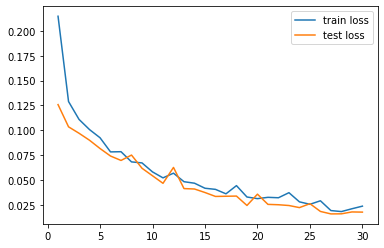

In [58]:
print(f'The model has {count_parameters(model):,} trainable parameters')
train_per_ep=[]
test_per_ep=[]
test_acc = 0
for epoch in range(EPOCHS):
    train_loss, train_acc = train_model(model, train_dataloader, optimizer, criterion, device)
    test_loss, test_acc = evaluate(model, train_dataloader,criterion, device)
    train_per_ep.append(train_loss)
    test_per_ep.append(test_loss)
    
    print(f'Epoch: {epoch + 1:02}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc * 100:.2f}%')
    print(f'Epoch: {epoch + 1:02}')
    print(f'\tTest Loss: {test_loss:.3f} | Test Acc: {test_acc * 100:.2f}%')

train_per_ep=np.array(train_per_ep)
test_per_ep=np.array(test_per_ep)
epocs=np.arange(1,EPOCHS+1)
print(np.mean(np.abs(np.array(train_per_ep) - np.array(test_per_ep))))
plt.figure()
plt.plot(epocs,train_per_ep)
plt.plot(epocs,test_per_ep)
plt.legend(['train loss','test loss'])
plt.show()